# config

In [60]:

!pip install git+https://github.com/philipperemy/keras-tcn.git@master


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/philipperemy/keras-tcn.git (to revision master) to /tmp/pip-req-build-hbf5dn4w
  Running command git clone -q https://github.com/philipperemy/keras-tcn.git /tmp/pip-req-build-hbf5dn4w


In [71]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tcn.tcn import TCN

# 1 step pred

                     OutboundUtilzation (%)
Timestamp                                  
2017-10-10 07:01:00                 96.2442
2017-10-10 07:21:00                 99.1131
2017-10-10 07:26:00                 97.2892
2017-10-10 07:31:00                 98.0286
2017-10-10 07:36:00                 99.5263
(287, 12, 1)
(287, 1)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_9 (TCN)                 (None, 64)                91136     
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 91,201
Trainable params: 91,201
Non-trainable params: 0
_________________________________________________________________
Train...
Epoch 1/100
9/9 - 2s - loss: 215.3587 - 2s/epoch - 228ms/step
Epoch 2/100
9/9 - 0s - loss: 82.5963 - 75ms/

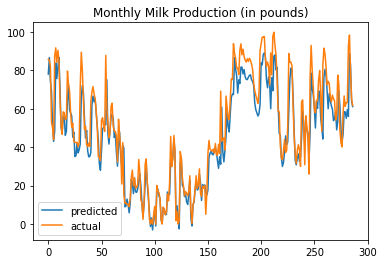

In [105]:
# https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line


##
# It's a very naive (toy) example to show how to do time series forecasting.
# - There are no training-testing sets here. Everything is training set for simplicity.
# - There is no input/output normalization.
# - The model is simple.
##

milk = pd.read_csv('/content/Network Analytics2.csv', index_col=0, parse_dates=True)

print(milk.head())

lookback_window = 12  # months.

milk = milk.values  # just keep np array here for simplicity.

x, y = [], []
for i in range(lookback_window, len(milk)):
    x.append(milk[i - lookback_window:i])
    y.append(milk[i])
x = np.array(x)
y = np.array(y)

print(x.shape)
print(y.shape)

# noinspection PyArgumentEqualDefault
model = Sequential([
    TCN(input_shape=(lookback_window, 1),
        kernel_size=2,
        use_skip_connections=False,
        use_batch_norm=False,
        use_weight_norm=False,
        use_layer_norm=False
        ),
    Dense(1, activation='linear')
])

model.summary()
model.compile('adam', 'mae')

print('Train...')
model.fit(x, y, epochs=100, verbose=2)

p = model.predict(x)

plt.plot(p)
plt.plot(y)
plt.title('Monthly Milk Production (in pounds)')
plt.legend(['predicted', 'actual'])
plt.show()

In [63]:
x.shape,y.shape

((287, 12, 1), (287, 1))

# 3 muti step pred test

In [149]:

milk = pd.read_csv('/content/Network Analytics2.csv', index_col=0, parse_dates=True)

print(milk.head())

lookback_window = 12  # months.
pred_window = 3  # months.

milk = milk.values # just keep np array here for simplicity.

x, y = [], []
for i in range(lookback_window, len(milk)-pred_window,pred_window):
    x.append(milk[i - lookback_window:i])
    y.append(milk[i:i+pred_window])

x,y
x = np.array(x,dtype=object).astype(np.float32)
y = np.array(y,dtype=object).astype(np.float32)
y = y.squeeze()





np.set_printoptions(threshold=5)
print(x.shape)
print(y.shape)

                     OutboundUtilzation (%)
Timestamp                                  
2017-10-10 07:01:00                 96.2442
2017-10-10 07:21:00                 99.1131
2017-10-10 07:26:00                 97.2892
2017-10-10 07:31:00                 98.0286
2017-10-10 07:36:00                 99.5263
(95, 12, 1)
(95, 3)


In [150]:

# noinspection PyArgumentEqualDefault
model = Sequential([
    TCN(input_shape=(lookback_window, 1),
        kernel_size=2,
        use_skip_connections=False,
        use_batch_norm=False,
        use_weight_norm=False,
        use_layer_norm=False
        ),
    Dense(pred_window, activation='linear')
])

model.summary()
model.compile('adam', 'mae')

print('Train...')
model.fit(x, y, epochs=100, verbose=2)


Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_13 (TCN)                (None, 64)                91136     
                                                                 
 dense_13 (Dense)            (None, 3)                 195       
                                                                 
Total params: 91,331
Trainable params: 91,331
Non-trainable params: 0
_________________________________________________________________
Train...
Epoch 1/100
3/3 - 2s - loss: 324.7466 - 2s/epoch - 537ms/step
Epoch 2/100
3/3 - 0s - loss: 126.7506 - 24ms/epoch - 8ms/step
Epoch 3/100
3/3 - 0s - loss: 92.3410 - 24ms/epoch - 8ms/step
Epoch 4/100
3/3 - 0s - loss: 52.2348 - 25ms/epoch - 8ms/step
Epoch 5/100
3/3 - 0s - loss: 47.0767 - 24ms/epoch - 8ms/step
Epoch 6/100
3/3 - 0s - loss: 30.7450 - 23ms/epoch - 8ms/step
Epoch 7/100
3/3 - 0s - loss: 36.1491 - 23ms/epoch - 8ms/step
Epoch 8

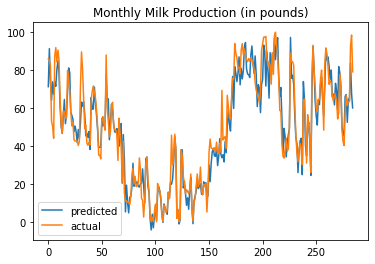

In [151]:

p = model.predict(x)
p = p.flatten()
y = y.flatten()
plt.plot(p)
plt.plot(y)
plt.title('Monthly Milk Production (in pounds)')
plt.legend(['predicted', 'actual'])
plt.show()

In [67]:
x.shape,y.shape

((287, 12, 1), (287, 1))

# TCN summary
## 1.  训练集即测试集（仅仅是过拟合）
## 2.  3-step-tcn 是将3步变成三维进行预测，从原理上有点小问题，即通过1-12预测13-15；但最好还是return_sequence = true,然后迭代预测，此时也是通过1-12预测13-15，没有新的点加入（即非自回归预测模型 ACF PACF）。

# lstm 1 step

![Imgur](https://i.imgur.com/FAGMvlc.png)
https://en.wikipedia.org/wiki/Long_short-term_memory

hidden state(also known as output of lstm units)restricted from minus one to one!!

In [130]:
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range
 
 
def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma

In [131]:

milk = pd.read_csv('/content/Network Analytics2.csv', index_col=0, parse_dates=True)
milk = normalization(milk)  #数据标准归一化
print(milk.head())

lookback_window = 12  # months.

milk = milk.values  # just keep np array here for simplicity.

x, y = [], []
for i in range(lookback_window, len(milk)):
    x.append(milk[i - lookback_window:i])
    y.append(milk[i])
x = np.array(x)
y = np.array(y)

print(x.shape)
print(y.shape)


                     OutboundUtilzation (%)
Timestamp                                  
2017-10-10 07:01:00                0.965234
2017-10-10 07:21:00                0.994015
2017-10-10 07:26:00                0.975718
2017-10-10 07:31:00                0.983135
2017-10-10 07:36:00                0.998160
(287, 12, 1)
(287, 1)


In [ ]:

# noinspection PyArgumentEqualDefault
model = Sequential([tf.keras.layers.LSTM(1,input_shape=(lookback_window, 1))

])

model.summary()
model.compile('adam', 'mae')

print('Train...')
model.fit(x, y, epochs=100, verbose=2)


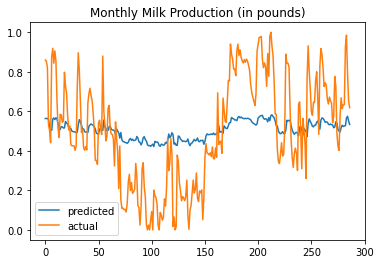

In [133]:

p = model.predict(x)

plt.plot(p)
plt.plot(y)
plt.title('Monthly Milk Production (in pounds)')
plt.legend(['predicted', 'actual'])
plt.show()

因为只有12个可调参数，根本学习不到特征


# lstm 3 step

In [152]:
def normalization(data):
    _range = np.max(data) - np.min(data)
    return ((data - np.min(data)) / _range)

In [153]:

milk = pd.read_csv('/content/Network Analytics2.csv', index_col=0, parse_dates=True)
milk = normalization(milk)  #数据标准归一化
print(milk.head())

lookback_window = 12  # months.
pred_window = 3  # months.

milk = milk.values # just keep np array here for simplicity.

x, y = [], []
for i in range(lookback_window, len(milk)-pred_window,pred_window):
    x.append(milk[i - lookback_window:i])
    y.append(milk[i:i+pred_window])

x,y
x = np.array(x,dtype=object).astype(np.float32)
y = np.array(y,dtype=object).astype(np.float32)
y = y.squeeze()





np.set_printoptions(threshold=5)
print(x.shape)
print(y.shape)

                     OutboundUtilzation (%)
Timestamp                                  
2017-10-10 07:01:00                0.965234
2017-10-10 07:21:00                0.994015
2017-10-10 07:26:00                0.975718
2017-10-10 07:31:00                0.983135
2017-10-10 07:36:00                0.998160
(95, 12, 1)
(95, 3)


In [ ]:

# noinspection PyArgumentEqualDefault
model = Sequential([tf.keras.layers.LSTM(3,input_shape=(lookback_window, 1))

])

model.summary()
model.compile('adam', 'mae')

print('Train...')
model.fit(x, y, epochs=100, verbose=2)


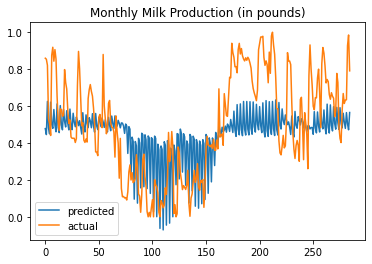

In [155]:

p = model.predict(x)
p = p.flatten()
y = y.flatten()
plt.plot(p)
plt.plot(y)
plt.title('Monthly Milk Production (in pounds)')
plt.legend(['predicted', 'actual'])
plt.show()